# Análisis y Modelado Analítico de Transacciones de Supermercado

In [2]:
import mercury as mr
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Configuración de la app Mercury
app = mr.App(
    title="Análisis de Transacciones de Supermercado",
    description="Dashboard interactivo para análisis descriptivo y diagnóstico de transacciones",
    show_code=False,
    show_prompt=False,
    continuous_update=True,
    static_notebook=False,
    show_sidebar=True,
    full_screen=True,
    allow_download=True,
    stop_on_error=False
)

## 1. Carga y Preparación de Datos

In [4]:
PRODUCTS_FOLDER = 'Products/'
TRANSACTIONS_FOLDER = 'Transactions/'

# Cargar categorías
categories_df = pd.read_csv(os.path.join(PRODUCTS_FOLDER, 'Categories.csv'), 
                           sep='|', header=None, names=['category_id', 'category_name'])

# Cargar relación producto-categoría
product_category_df = pd.read_csv(os.path.join(PRODUCTS_FOLDER, 'ProductCategory.csv'), sep='|')

# Cargar transacciones
transaction_files = glob(os.path.join(TRANSACTIONS_FOLDER, '*_Tran.csv'))
transactions_dfs = []

for file in transaction_files:
    df = pd.read_csv(file, sep='|', header=None, 
                    names=['date', 'store_id', 'customer_id', 'products'])
    df['products'] = df['products'].str.split(' ')
    transactions_dfs.append(df)

all_transactions_df = pd.concat(transactions_dfs, ignore_index=True)
all_transactions_df['products'] = all_transactions_df['products'].apply(tuple)
all_transactions_df['date'] = pd.to_datetime(all_transactions_df['date'])
all_transactions_df['num_products'] = all_transactions_df['products'].apply(len)

# Expandir productos
exploded_products = all_transactions_df.explode('products')
exploded_products['product_id'] = pd.to_numeric(exploded_products['products'], errors='coerce')
exploded_products = exploded_products.merge(product_category_df, 
                                           left_on='product_id', 
                                           right_on='v.Code_pr', how='left')
exploded_products.rename(columns={'v.code': 'category_id'}, inplace=True)
exploded_products = exploded_products.merge(categories_df, on='category_id', how='left')

mr.Md("### ✅ Datos cargados exitosamente")

## 2. Resumen Ejecutivo

In [ ]:
mr.Md("## 📊 Resumen Ejecutivo")

# Calcular métricas clave
total_ventas = all_transactions_df['num_products'].sum()
num_transacciones = len(all_transactions_df)
num_clientes = all_transactions_df['customer_id'].nunique()
num_productos = exploded_products['product_id'].nunique()

In [ ]:
# Mostrar métricas principales con NumberBox
mr.NumberBox(
    data=int(total_ventas),
    title="Total de Unidades Vendidas",
    background_color="#e3f2fd"
)

mr.NumberBox(
    data=num_transacciones,
    title="Número de Transacciones",
    background_color="#f3e5f5"
)

mr.NumberBox(
    data=num_clientes,
    title="Clientes Únicos",
    background_color="#e8f5e9"
)

mr.NumberBox(
    data=num_productos,
    title="Productos Únicos",
    background_color="#fff3e0"
)

### Top 10 Productos Más Vendidos

In [ ]:
top_productos = exploded_products['product_id'].value_counts().head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_productos)), top_productos.values, color='steelblue')
plt.yticks(range(len(top_productos)), [f"Producto {int(p)}" for p in top_productos.index])
plt.xlabel('Frecuencia de Compra')
plt.title('Top 10 Productos Más Comprados')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Top 10 Clientes

In [ ]:
top_clientes = all_transactions_df['customer_id'].value_counts().head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_clientes)), top_clientes.values, color='coral')
plt.yticks(range(len(top_clientes)), [f"Cliente {int(c)}" for c in top_clientes.index])
plt.xlabel('Número de Compras')
plt.title('Top 10 Clientes con Mayor Número de Compras')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Categorías Más Populares

In [ ]:
category_dist = exploded_products['category_name'].value_counts().head(10)

plt.figure(figsize=(10, 6))
plt.pie(category_dist.values, labels=category_dist.index, autopct='%1.1f%%', startangle=90)
plt.title('Top 10 Categorías Más Compradas')
plt.axis('equal')
plt.tight_layout()
plt.show()

## 3. Visualizaciones Analíticas

In [ ]:
mr.Md("## 📈 Visualizaciones Analíticas")

### Serie de Tiempo - Ventas por Día

In [ ]:
transactions_per_day = all_transactions_df.groupby(all_transactions_df['date'].dt.date).size()

plt.figure(figsize=(14, 6))
transactions_per_day.plot(color='darkblue', linewidth=1.5)
plt.title('Número de Transacciones por Día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Transacciones')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Boxplot - Distribución de Productos por Cliente

In [ ]:
cliente_productos = all_transactions_df.groupby('customer_id')['num_products'].sum()

plt.figure(figsize=(10, 6))
sns.boxplot(x=cliente_productos, color='lightgreen')
plt.title('Distribución de Total de Productos por Cliente')
plt.xlabel('Total de Productos Comprados')
plt.tight_layout()
plt.show()

mr.Md(f"""
**Estadísticas:**
- Media: {cliente_productos.mean():.2f}
- Mediana: {cliente_productos.median():.2f}
- Desviación Estándar: {cliente_productos.std():.2f}
""")

### Heatmap - Correlación entre Variables

In [ ]:
# Crear matriz de correlación
customer_features = all_transactions_df.groupby('customer_id').agg({
    'num_products': ['sum', 'mean'],
    'date': 'count',
    'store_id': 'nunique'
})
customer_features.columns = ['total_productos', 'promedio_productos', 'frecuencia', 'tiendas_visitadas']

correlation_matrix = customer_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlación entre Variables de Comportamiento del Cliente')
plt.tight_layout()
plt.show()

## 4. Análisis Temporal

In [ ]:
mr.Md("## 📅 Análisis Temporal")

# Extraer características temporales
all_transactions_df['dia_semana'] = all_transactions_df['date'].dt.day_name()
all_transactions_df['hora_dia'] = all_transactions_df['date'].dt.hour

### Ventas por Día de la Semana

In [ ]:
ventas_dia_semana = all_transactions_df.groupby('dia_semana')['num_products'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(12, 6))
plt.bar(ventas_dia_semana.index, ventas_dia_semana.values, color='teal')
plt.title('Ventas por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Total Ventas')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Ventas por Hora del Día

In [ ]:
ventas_hora = all_transactions_df.groupby('hora_dia')['num_products'].sum()

plt.figure(figsize=(12, 6))
plt.plot(ventas_hora.index, ventas_hora.values, marker='o', linewidth=2, color='darkred')
plt.title('Ventas por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Total Ventas')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Tendencias y Estacionalidad

In [ ]:
serie_temporal = all_transactions_df.set_index('date')['num_products'].resample('D').sum()

df_temporal = serie_temporal.reset_index()
df_temporal.columns = ['fecha', 'ventas']
df_temporal['media_movil_7d'] = df_temporal['ventas'].rolling(window=7, min_periods=1).mean()
df_temporal['media_movil_30d'] = df_temporal['ventas'].rolling(window=30, min_periods=1).mean()

plt.figure(figsize=(14, 6))
plt.plot(df_temporal['fecha'], df_temporal['ventas'], alpha=0.3, label='Ventas Diarias')
plt.plot(df_temporal['fecha'], df_temporal['media_movil_7d'], label='Media Móvil 7 días', linewidth=2)
plt.plot(df_temporal['fecha'], df_temporal['media_movil_30d'], label='Media Móvil 30 días', linewidth=2)
plt.title('Tendencia de Ventas con Medias Móviles')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Análisis por Cliente

In [ ]:
mr.Md("## 👥 Análisis por Cliente")

# Calcular comportamiento del cliente
all_transactions_df = all_transactions_df.sort_values(by=['customer_id', 'date'])
all_transactions_df['prev_date'] = all_transactions_df.groupby('customer_id')['date'].shift()
all_transactions_df['days_between'] = (all_transactions_df['date'] - all_transactions_df['prev_date']).dt.days

comportamiento_cliente = all_transactions_df.groupby('customer_id').agg({
    'date': ['count', 'min', 'max'],
    'num_products': 'sum',
    'store_id': 'nunique',
    'days_between': 'mean'
})

comportamiento_cliente.columns = ['total_compras', 'primera_compra', 'ultima_compra', 
                                  'total_productos', 'tiendas_visitadas', 'dias_entre_compras']

### Distribución de Frecuencia de Compra

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(comportamiento_cliente['total_compras'], bins=50, edgecolor='black', color='skyblue')
plt.title('Distribución de Número de Compras por Cliente')
plt.xlabel('Número de Compras')
plt.ylabel('Número de Clientes')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

mr.Md(f"""
**Estadísticas de Frecuencia:**
- Compras promedio por cliente: {comportamiento_cliente['total_compras'].mean():.2f}
- Mediana de compras: {comportamiento_cliente['total_compras'].median():.2f}
""")

### Tiempo Promedio entre Compras

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(comportamiento_cliente['dias_entre_compras'].dropna(), bins=50, 
         edgecolor='black', color='lightcoral')
plt.title('Distribución del Tiempo Promedio entre Compras')
plt.xlabel('Días entre Compras')
plt.ylabel('Número de Clientes')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

mr.Md(f"""
**Estadísticas de Intervalo:**
- Intervalo promedio: {comportamiento_cliente['dias_entre_compras'].mean():.2f} días
- Mediana: {comportamiento_cliente['dias_entre_compras'].median():.2f} días
""")

### Segmentación de Clientes

In [ ]:
customer_freq = all_transactions_df['customer_id'].value_counts().reset_index(name='freq')

customer_segments = pd.DataFrame({
    "freq": customer_freq.set_index('customer_id')['freq'],
    "avg_purchase_interval": all_transactions_df.groupby('customer_id')['days_between'].mean()
})

customer_segments['freq_segment'] = pd.cut(
    customer_segments['freq'],
    bins=[0, 2, 5, 10, 1000],
    labels=["Ocasional", "Moderado", "Frecuente", "Muy Frecuente"]
)

customer_segments['interval_segment'] = pd.cut(
    customer_segments['avg_purchase_interval'],
    bins=[0, 5, 15, 30, 1000],
    labels=["Muy Frecuente", "Frecuente", "Moderado", "Ocasional"]
)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

customer_segments['freq_segment'].value_counts().sort_index().plot(
    kind='bar', color='steelblue', edgecolor='black', ax=axes[0]
)
axes[0].set_title('Segmentación por Frecuencia de Compra')
axes[0].set_xlabel('Segmento')
axes[0].set_ylabel('Número de Clientes')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

customer_segments['interval_segment'].value_counts().sort_index().plot(
    kind='bar', color='lightgreen', edgecolor='black', ax=axes[1]
)
axes[1].set_title('Segmentación por Intervalo de Compra')
axes[1].set_xlabel('Segmento')
axes[1].set_ylabel('Número de Clientes')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Análisis Avanzado

In [ ]:
mr.Md("## 🔬 Análisis Avanzado")

### A. Segmentación de Clientes con K-Means

In [5]:
transacciones= all_transactions_df.copy()

In [ ]:
mr.Md("""
### Segmentación de Clientes con K-Means

*Espacio reservado para implementación de clustering*

**Variables sugeridas:**
- Frecuencia de compra
- Número de productos distintos
- Volumen total
- Diversidad de categorías
""")

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Preparar datos para clustering
def preparar_datos_clustering(transacciones, product_category, categories):
    """
    Preparar dataset para clustering con las variables sugeridas
    """
    # Merge para obtener categorías de productos
    # SOLUCIÓN CORREGIDA
    transacciones_con_categorias = transacciones.merge(
        product_category.astype({'v.Code_pr': 'object'}),  # Convertir a object para que coincida
        left_on='products',
        right_on='v.Code_pr',
        how='left'
    ).merge(
        categories,
        left_on='v.code',
        right_on='category_id',
        how='left'
    )

    # Calcular métricas por cliente
    metrics_per_customer = transacciones_con_categorias.groupby('customer_id').agg({
        'date': ['count', 'nunique'],  # Frecuencia y días distintos de compra
        'products': 'nunique',         # Número de productos distintos
        'num_products': 'sum',         # Volumen total de productos
        'category_name': 'nunique'     # Diversidad de categorías
    }).round(2)

    # Limpiar nombres de columnas
    metrics_per_customer.columns = ['frecuencia', 'dias_compra', 'productos_distintos',
                                   'volumen_total', 'diversidad_categorias']

    # Calcular recencia
    ultima_fecha = transacciones['date'].max()
    recencia_clientes = transacciones.groupby('customer_id')['date'].max()
    metrics_per_customer['recencia'] = (ultima_fecha - recencia_clientes).dt.days

    # Calcular ticket promedio
    metrics_per_customer['ticket_promedio'] = (
        metrics_per_customer['volumen_total'] / metrics_per_customer['frecuencia']
    )

    return metrics_per_customer.reset_index()

# Preparar datos
datos_clustering = preparar_datos_clustering(transacciones, product_category_df, categories_df)

print("=== RESUMEN DATOS PARA CLUSTERING ===")
print(f"Clientes para clustering: {len(datos_clustering)}")
print("\nEstadísticas descriptivas:")
print(datos_clustering.describe())

=== RESUMEN DATOS PARA CLUSTERING ===
Clientes para clustering: 131186

Estadísticas descriptivas:
        customer_id     frecuencia    dias_compra  productos_distintos  \
count  1.311860e+05  131186.000000  131186.000000        131186.000000   
mean   5.015653e+05       8.453547       8.425442             8.340410   
std    2.918809e+05      11.275340      11.125597            11.079308   
min    5.000000e+00       1.000000       1.000000             1.000000   
25%    2.493598e+05       1.000000       1.000000             1.000000   
50%    4.991820e+05       4.000000       4.000000             4.000000   
75%    7.534518e+05      11.000000      11.000000            11.000000   
max    1.009515e+06     535.000000     180.000000           475.000000   

       volumen_total  diversidad_categorias       recencia  ticket_promedio  
count  131186.000000               131186.0  131186.000000    131186.000000  
mean       80.738745                    0.0      44.473534         8.024389  


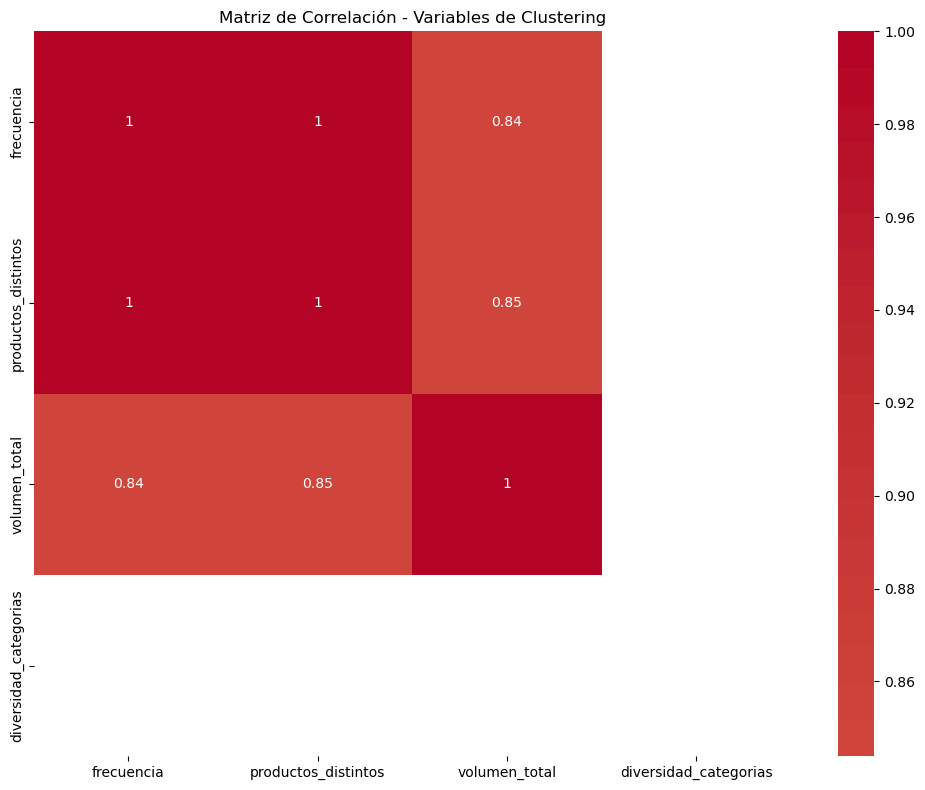

In [7]:
# Seleccionar variables para clustering
variables_clustering = [
    'frecuencia',           # Frecuencia de compra
    'productos_distintos',  # Número de productos distintos comprados
    'volumen_total',        # Volumen total de productos
    'diversidad_categorias' # Número de categorías distintas
]

X = datos_clustering[variables_clustering]

# Estandarizar variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Verificar correlación entre variables
plt.figure(figsize=(10, 8))
correlation_matrix = datos_clustering[variables_clustering].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación - Variables de Clustering')
plt.tight_layout()
plt.show()

In [11]:
# Aplicar K-Means con k óptimo (ajustar según resultados del método del codo)
k_optimo = 5  # Cambiar según lo que indique el método del codo

kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Añadir clusters al dataset
datos_clustering['cluster'] = clusters

print(f"=== DISTRIBUCIÓN DE CLUSTERS (k={k_optimo}) ===")
distribucion_clusters = datos_clustering['cluster'].value_counts().sort_index()
print(distribucion_clusters)

=== DISTRIBUCIÓN DE CLUSTERS (k=5) ===
cluster
0    82583
1    13503
2    27903
3     1349
4     5848
Name: count, dtype: int64


In [ ]:
# Reducción dimensional para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear DataFrame para visualización
df_viz = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_viz['cluster'] = clusters
df_viz['customer_id'] = datos_clustering['customer_id']

# Visualización 2D de clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_viz['PC1'], df_viz['PC2'], c=df_viz['cluster'],
                     cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter)
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
plt.title('Visualización de Clusters de Clientes (PCA)')
plt.grid(True, alpha=0.3)
plt.show()

# Boxplots por cluster y variable
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
variables = ['frecuencia', 'productos_distintos', 'volumen_total', 'diversidad_categorias']

for i, var in enumerate(variables):
    row, col = i // 2, i % 2
    datos_clustering.boxplot(column=var, by='cluster', ax=axes[row, col])
    axes[row, col].set_title(f'Distribución de {var} por Cluster')
    axes[row, col].set_ylabel(var)

plt.suptitle('Análisis de Variables por Cluster')
plt.tight_layout()
plt.show()

In [ ]:
# Heatmap de características por cluster
caracteristicas_cluster = datos_clustering.groupby('cluster')[variables_clustering].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(caracteristicas_cluster, annot=True, cmap='YlOrRd', fmt='.2f', linewidths=0.5)
plt.title('Heatmap de Características Promedio por Cluster')
plt.tight_layout()
plt.show()

# Radar chart para comparar clusters
from math import pi

def crear_radar_chart(clusters_data, variables):
    """Crear gráfico radar para comparar clusters"""

    # Normalizar datos para radar chart
    normalized_data = clusters_data[variables].copy()
    for var in variables:
        normalized_data[var] = (clusters_data[var] - clusters_data[var].min()) / (clusters_data[var].max() - clusters_data[var].min())

    # Configurar ángulos
    categories = variables
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Crear figura
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    # Colores para cada cluster
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for idx, cluster_id in enumerate(clusters_data.index):
        values = normalized_data.loc[cluster_id].values.flatten().tolist()
        values += values[:1]

        ax.plot(angles, values, 'o-', linewidth=2,
               label=f'Cluster {cluster_id} (n={clusters_data.loc[cluster_id, "tamaño"]})',
               color=colors[idx])
        ax.fill(angles, values, alpha=0.1, color=colors[idx])

    # Añadir etiquetas
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.title('Perfil de Clusters - Comparación de Características')
    plt.show()

# Preparar datos para radar chart
clusters_radar = df_perfiles.set_index('cluster')[['frecuencia_promedio', 'productos_distintos_promedio',
                                                  'volumen_total_promedio', 'diversidad_categorias_promedio']]
clusters_radar['tamaño'] = df_perfiles['tamaño'].values

crear_radar_chart(clusters_radar, ['frecuencia_promedio', 'productos_distintos_promedio',
                                  'volumen_total_promedio', 'diversidad_categorias_promedio'])

In [ ]:
# Generar descripción automática de clusters
def generar_descripcion_clusters(df_perfiles):
    descripciones = []

    for _, cluster in df_perfiles.iterrows():
        # Determinar características principales
        if cluster['frecuencia_promedio'] > df_perfiles['frecuencia_promedio'].mean():
            freq_desc = "ALTA frecuencia"
        else:
            freq_desc = "BAJA frecuencia"

        if cluster['volumen_total_promedio'] > df_perfiles['volumen_total_promedio'].mean():
            vol_desc = "ALTO volumen"
        else:
            vol_desc = "BAJO volumen"

        if cluster['diversidad_categorias_promedio'] > df_perfiles['diversidad_categorias_promedio'].mean():
            div_desc = "ALTA diversidad"
        else:
            div_desc = "BAJA diversidad"

        descripcion = f"""
        CLUSTER {int(cluster['cluster'])} - {cluster['tamaño']} clientes ({cluster['porcentaje']:.1f}%)
        • Perfil: {freq_desc}, {vol_desc}, {div_desc}
        • Compras promedio: {cluster['frecuencia_promedio']:.1f}
        • Productos distintos: {cluster['productos_distintos_promedio']:.1f}
        • Volumen total: {cluster['volumen_total_promedio']:.1f}
        • Categorías: {cluster['diversidad_categorias_promedio']:.1f}
        • Recencia: {cluster['recencia_promedio']:.1f} días
        • Ticket promedio: {cluster['ticket_promedio']:.1f}
        """
        descripciones.append(descripcion)

    return descripciones

# Generar y mostrar descripciones
descripciones_clusters = generar_descripcion_clusters(df_perfiles)
print("=== DESCRIPCIÓN DE CLUSTERS ===")
for desc in descripciones_clusters:
    print(desc)

# Generar recomendaciones de negocio
def generar_recomendaciones(df_perfiles):
    recomendaciones = []

    for _, cluster in df_perfiles.iterrows():
        cluster_id = int(cluster['cluster'])

        if cluster['frecuencia_promedio'] > df_perfiles['frecuencia_promedio'].mean():
            if cluster['volumen_total_promedio'] > df_perfiles['volumen_total_promedio'].mean():
                # Clientes valiosos
                recomendacion = f"""
                CLUSTER {cluster_id} - CLIENTES VALIOSOS
                ✓ Estrategia: Retención y fidelización
                ✓ Acciones:
                   - Programas de loyalty exclusivos
                   - Atención personalizada
                   - Ofertas premium y early access
                   - Encuestas de satisfacción regulares
                """
            else:
                # Clientes frecuentes pero de bajo volumen
                recomendacion = f"""
                CLUSTER {cluster_id} - CLIENTES FRECUENTES
                ✓ Estrategia: Aumentar ticket promedio
                ✓ Acciones:
                   - Cross-selling de productos complementarios
                   - Ofertas de bundles y paquetes
                   - Programas de acumulación de puntos
                """
        else:
            if cluster['volumen_total_promedio'] > df_perfiles['volumen_total_promedio'].mean():
                # Clientes de alto volumen pero baja frecuencia
                recomendacion = f"""
                CLUSTER {cluster_id} - COMPRADORES OCASIONALES GRANDES
                ✓ Estrategia: Aumentar frecuencia
                ✓ Acciones:
                   - Recordatorios de recompra
                   - Ofertas por compras recurrentes
                   - Programas de suscripción
                """
            else:
                # Clientes de bajo engagement
                recomendacion = f"""
                CLUSTER {cluster_id} - CLIENTES OCASIONALES/EN RIESGO
                ✓ Estrategia: Reactivación y engagement
                ✓ Acciones:
                   - Campañas de re-engagement
                   - Ofertas de bienvenida de vuelta
                   - Contenido educativo sobre productos
                   - Encuestas para entender abandono
                """

        recomendaciones.append(recomendacion)

    return recomendaciones

print("=== RECOMENDACIONES DE NEGOCIO ===")
recomendaciones = generar_recomendaciones(df_perfiles)
for rec in recomendaciones:
    print(rec)

### B. Sistema de Recomendación de Productos

In [ ]:
mr.Md("## 🎯 Sistema de Recomendación de Productos")

# Cargar reglas de asociación
try:
    rules = pd.read_pickle("association_rules.pkl")
    mr.Md("✅ **Reglas de asociación cargadas correctamente**")
except FileNotFoundError:
    mr.Md("⚠️ **Archivo 'association_rules.pkl' no encontrado**")
    rules = None

In [ ]:
# Widget para seleccionar tipo de recomendación
tipo_recomendacion = mr.Select(
    value="cliente",
    choices=["cliente", "producto"],
    label="Tipo de Recomendación"
)

# Widgets condicionales - definir ambos pero con valores por defecto
if tipo_recomendacion.value == "cliente":
    cliente_id_selector = mr.Numeric(
        value=530,
        label="ID del Cliente",
        min=1,
        max=999999,
        step=1
    )
    cliente_id = cliente_id_selector.value
    producto_id = 20  # Valor por defecto cuando no se usa
    
else:
    producto_id_selector = mr.Numeric(
        value=20,
        label="ID del Producto",
        min=1,
        max=999999,
        step=1
    )
    producto_id = producto_id_selector.value
    cliente_id = 530  # Valor por defecto cuando no se usa

# Número de recomendaciones (común para ambos)
num_recomendaciones_selector = mr.Slider(
    value=5,
    min=1,
    max=20,
    step=1,
    label="Número de Recomendaciones"
)

num_recomendaciones = num_recomendaciones_selector.value

In [ ]:
# Mostrar título según tipo de recomendación
if tipo_recomendacion.value == "cliente":
    mr.Md(f"### Recomendaciones para Cliente {cliente_id}")
else:
    mr.Md(f"### Recomendaciones para Producto {producto_id}")

#### Funciones de Recomendación

In [ ]:
def mapear_categorias_productos(product_ids):
    """Mapea IDs de productos a sus categorías"""
    mapeo = product_category_df.merge(categories_df, left_on='v.code', 
                                     right_on='category_id', how='left')
    mapeo = mapeo[['v.Code_pr', 'category_name']].drop_duplicates()
    return pd.Series(product_ids).map(dict(zip(mapeo['v.Code_pr'], mapeo['category_name'])))

def recomendar_por_cliente(cliente_id, top_n=5):
    """Recomienda productos para un cliente usando filtrado colaborativo"""
    cliente_producto = exploded_products.groupby(['customer_id', 'product_id']).size().unstack(fill_value=0)
    cliente_producto = (cliente_producto > 0).astype(int)
    
    if cliente_id not in cliente_producto.index:
        return f"Cliente {cliente_id} no encontrado."
    
    cliente_vector = cliente_producto.loc[[cliente_id]]
    similitudes = cosine_similarity(cliente_vector, cliente_producto)[0]
    sim_series = pd.Series(similitudes, index=cliente_producto.index).sort_values(ascending=False)[1:50]
    
    clientes_similares = sim_series.index
    productos_cliente = set(cliente_producto.loc[cliente_id][cliente_producto.loc[cliente_id] > 0].index)
    
    productos_similares = cliente_producto.loc[clientes_similares]
    productos_prom = productos_similares.mean().sort_values(ascending=False)
    
    recomendaciones = productos_prom[~productos_prom.index.isin(productos_cliente)].head(top_n)
    return list(recomendaciones.index)

def recomendar_por_producto(id, top_n=5):
    """Recomienda productos complementarios usando reglas de asociación"""
    if rules is None:
        return "Reglas de asociación no disponibles"
    
    try:
        producto_id = int(float(id))
    except (ValueError, TypeError):
        return f"ID de producto inválido: {id}"

    mask = rules['antecedents'].apply(lambda x: x == frozenset([producto_id]))
    recomendaciones = rules[mask]
    
    if recomendaciones.empty:
        return f"No hay reglas disponibles para el producto {producto_id}."
    
    recomendaciones = recomendaciones.sort_values(by='lift', ascending=False).head(top_n)
    return recomendaciones[['antecedents', 'consequents', 'confidence', 'lift']]

In [ ]:
# Ejecutar recomendación según tipo seleccionado
if tipo_recomendacion.value == "cliente":
    recomendaciones = recomendar_por_cliente(cliente_id, num_recomendaciones)
    
    if isinstance(recomendaciones, str):
        mr.Md(f"⚠️ {recomendaciones}")
    else:
        mr.Md("#### Productos Recomendados:")
        
        # Crear DataFrame con recomendaciones
        df_recom = pd.DataFrame({
            'Producto ID': recomendaciones,
            'Categoría': mapear_categorias_productos(recomendaciones)
        })
        
        mr.Table(data=df_recom, text_align="left")
        

else:
    recomendaciones = recomendar_por_producto(producto_id, num_recomendaciones)
    
    if isinstance(recomendaciones, str):
        mr.Md(f"⚠️ {recomendaciones}")
    else:
        mr.Md("#### Productos que se Compran Juntos:")
        
        # Mostrar tabla de reglas
        df_display = recomendaciones.copy()
        df_display['antecedents'] = df_display['antecedents'].apply(lambda x: ', '.join(map(str, x)))
        df_display['consequents'] = df_display['consequents'].apply(lambda x: ', '.join(map(str, x)))
        
        mr.Table(data=df_display, text_align="left")
        

## 7. Conclusiones

In [ ]:
mr.Md("""
## 📋 Conclusiones Principales

### Hallazgos Clave:

1. **Patrones Temporales:**
   - Identificación de días y horas pico de ventas
   - Tendencias estacionales en el comportamiento de compra

2. **Comportamiento del Cliente:**
   - Segmentación clara de clientes por frecuencia y recencia
   - Identificación de clientes de alto valor

3. **Análisis de Productos:**
   - Productos y categorías más populares
   - Relaciones de compra complementaria

4. **Sistema de Recomendación:**
   - Implementación de filtrado colaborativo para clientes
   - Uso de reglas de asociación para productos complementarios

### Aplicaciones Empresariales:

- **Marketing Personalizado:** Usar segmentación para campañas dirigidas
- **Gestión de Inventario:** Optimizar stock basado en patrones de venta
- **Cross-selling:** Implementar recomendaciones en punto de venta
- **Programas de Lealtad:** Diseñar incentivos para diferentes segmentos
""")

In [ ]:
mr.Md("---")
mr.Md("**Desarrollado para Análisis de Transacciones de Supermercado** | Dashboard Interactivo con Mercury")